In [1]:
import sys
sys.path.append("../")
from src.data.common import DownloadedRepositories, load_repositories_json

from pathlib import Path

import json
import tqdm
from src.utils.compare import diff_to_conversation

from joblib import Parallel, delayed

In [2]:
repos = load_repositories_json(Path('../data/repositories_download_status.json'))

Loading info about cloned repos from '../data/repositories_download_status.json'...


In [3]:
with open("../data/external/DevGPT/snapshot_20230914/20230914_083202_commit_sharings.json") as f:
    data = json.load(f)

In [4]:
all_repos = DownloadedRepositories(Path('../data/repositories_download_status.json'))


# get url
diffs = {}
bad_url = []
for source in tqdm.tqdm(data['Sources']):

    try:
        R = source['RepoName']
        S  = source['Sha']
        the_repo = all_repos.repo(R)
        curr_diff = the_repo.unidiff(S) 
        diffs[(R,S)] = curr_diff
    except:
        bad_url.append((R,S))

Loading info about cloned repos from '../data/repositories_download_status.json'...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 571/571 [00:06<00:00, 81.92it/s]


In [5]:
def run_joblib(conv):
    
    if 'Conversations' not in conv:
        return {}
    
    R = source['RepoName']
    S  = source['Sha']

    if ((R,S) in diffs):
        return diff_to_conversation(diffs[(R,S)], conv)
    
    return {}

In [6]:
ret = Parallel(n_jobs=600)(delayed(run_joblib)(conv) for source in tqdm.tqdm(data['Sources']) for conv in source['ChatgptSharing'])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 571/571 [00:00<00:00, 24942.69it/s]


In [7]:
# for source in tqdm.tqdm(data['Sources']):
#     for conv in source['ChatgptSharing']:
#         print(run_joblib(conv))
#         break

In [7]:
df = []
for r in ret:
    if 'ALL' in r:
        df.append({'cov' : r['ALL']['coverage'], 'all': r['ALL']['all']})

In [8]:
import pandas as pd

In [9]:
df = pd.DataFrame(df)

In [10]:
df['%'] = df['cov']/df['all']

In [11]:
import seaborn as sns

<AxesSubplot: xlabel='%', ylabel='Count'>

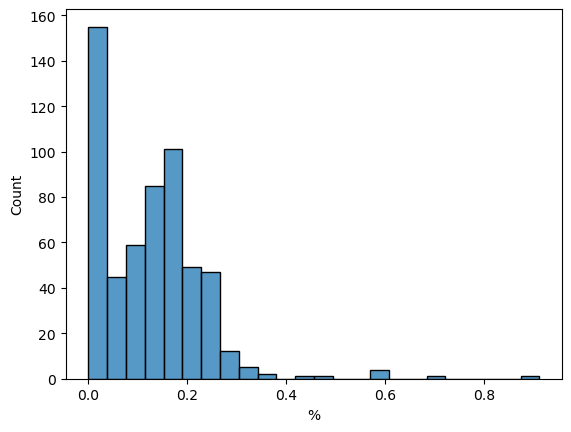

In [12]:
sns.histplot(df, x='%')